---
layout: post
title:  "Propagating (non-gaussian) uncertainty"
desc: "From samples back to model confidence regions"
date: 2019-08-02
categories: [tutorial]
tags: [bayesian]
loc: 'tutorials/propagating/'
math: true
---

!!!replace

You've fit a model to some data. You have some mean, covariance or samples characterising that fit, but now how can you clearly show the $1$ and $2\sigma$ confidence regions of this fit back onto your model. In other words, how do you get this sort of image back at the end:

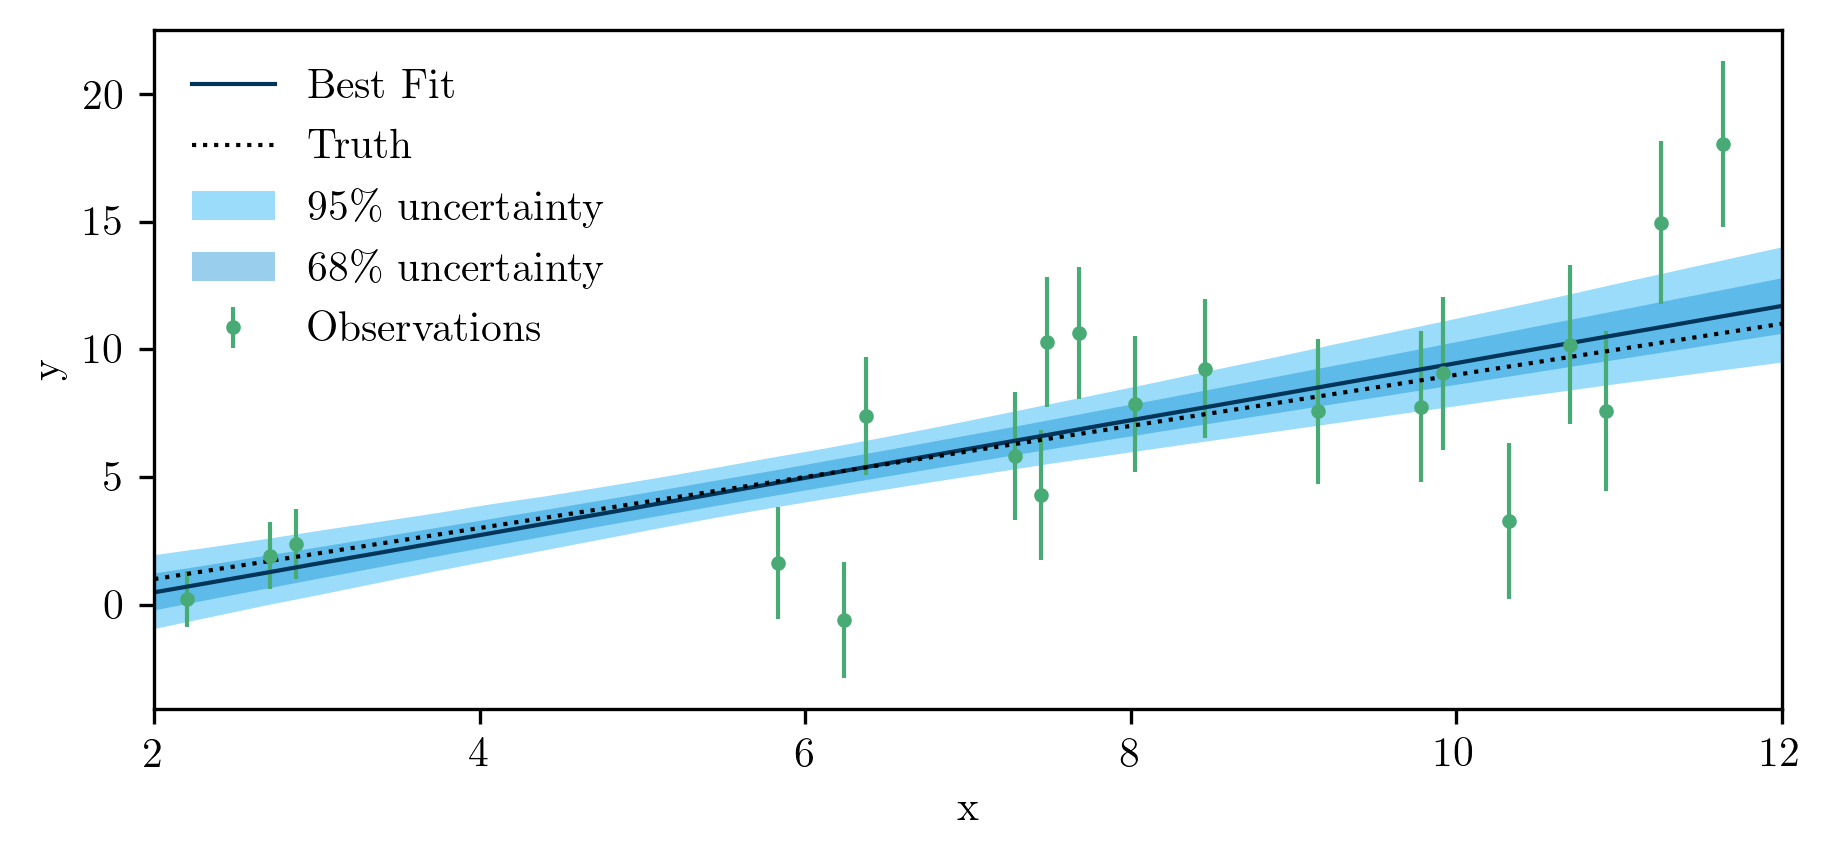

In [91]:
from scipy.stats import norm
import emcee
import matplotlib.pyplot as plt
import numpy as np

num_points = 20
m, c = np.tan(np.pi / 4), -1
np.random.seed(0)
xs = np.random.uniform(size=num_points) * 10 + 2
ys = m * xs + c
err = np.sqrt(ys)
ys += err * np.random.normal(size=num_points)

def log_prior(xs):
    phi, c = xs
    if np.abs(phi) > np.pi / 2:
        return -np.inf
    return 0
def log_likelihood(xs, data):
    phi, c = xs
    xobs, yobs, eobs = data
    model = np.tan(phi) * xobs + c
    diff = model - yobs
    return norm.logpdf(diff / eobs).sum()
def log_posterior(xs, data):
    prior = log_prior(xs)
    if not np.isfinite(prior):
        return prior
    return prior + log_likelihood(xs, data)

ndim = 2  # How many parameters we are fitting
nwalkers = 50  # Keep this well above your dimensionality.
p0 = np.random.uniform(low=-1.5, high=1.5, size=(nwalkers, ndim))  # Start points
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[(xs, ys, err)])
state = sampler.run_mcmc(p0, 300)  # Tell each walker to take 2000 steps
chain = sampler.chain[:, 100:, :]  # Throw out the first hundred steps
flat_chain = chain.reshape((-1, ndim))  # Stack the steps from each walker 

x_vals = np.linspace(2, 12, 30)
# Calculate range our uncertainty gives using 2D matrix multplication
realisations = np.tan(flat_chain[:, 0][:, None]) * x_vals + flat_chain[:, 1][:, None]
bounds = np.percentile(realisations, 100 * norm.cdf([-2, -1, 0, 1, 2]), axis=0)

# Plot everything
fig, ax = plt.subplots()
ax.errorbar(xs, ys, yerr=err, fmt='.', label="Observations", c="#48AB75", ms=5, lw=1)
ax.plot(x_vals, bounds[2, :], label="Best Fit", ls="-", c="#003459")
ax.plot(x_vals, x_vals - 1, label="Truth", c="k", ls=":", lw=1)
plt.fill_between(x_vals, bounds[0, :], bounds[-1, :], 
                 label="95\% uncertainty", fc="#03A9F4", alpha=0.4)
plt.fill_between(x_vals, bounds[1, :], bounds[-2, :], 
                 label="68\% uncertainty", fc="#0288D1", alpha=0.4)
ax.legend(frameon=False, loc=2)
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_xlim(2, 12);

In [92]:
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif')

Let's run through a bunch of different ways, depending on how you've fit your model to the data. Firstly, let's generate a model and some fake data to fit it with. In our case, lets have a function `fn` which implements $f(x) = a\sin(x) + ba$, where our 'true' values for $a$ and $b$ will both be $1$ for simplicity. Why this - no particular reason, you can use anything, but this will explicitly not give Gaussian uncertainty, which makes it a more general use case.

From that function, we'll sample $20$ points, add some error, and then plot them.

In [100]:
# Remove
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 3)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['hist.bins'] = 50
plt.rcParams['lines.markersize'] = 2
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['legend.frameon'] = False
from cycler import cycler	  
# plt.rcParams['axes.prop_cycle'] = (cycler(color=["#31338c","#ad3780","#e86762","#f2af55"]) + cycler(linestyle=['-', '--', ':', '-.']))
plt.rcParams['axes.prop_cycle'] = (cycler(color=["#673AB7","#03A9F4","#D32F2F","#FFA000"]) + cycler(linestyle=['-', '--', ':', '-.']))


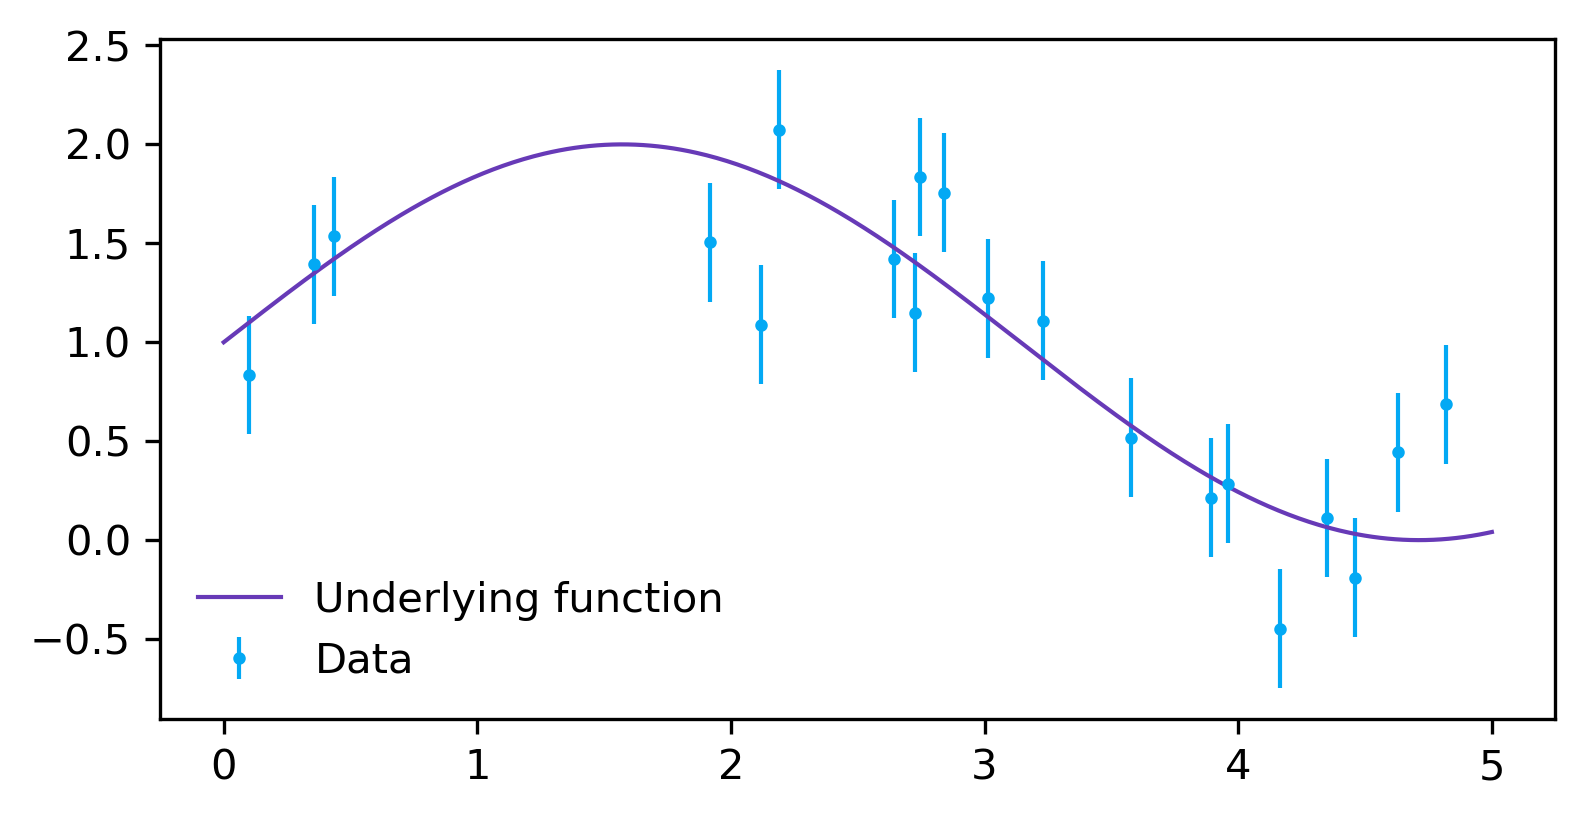

In [101]:
import numpy as np
import matplotlib.pyplot as plt

def fn(xs, a=1, b=1):
    return a * np.sin(xs) + b * a

truth = [1, 1]
x_val = np.linspace(0, 5, 500)
y_val = fn(x_val)

num_samps, err = 20, 0.3
np.random.seed(0)
x_samps = np.random.uniform(size=num_samps) * 5
y_samps = fn(x_samps) + err * np.random.normal(size=num_samps)

plt.plot(x_val, y_val, label="Underlying function")
plt.errorbar(x_samps, y_samps, yerr=err, fmt="o", lw=1, label="Data")
plt.legend(loc=3);

Now, let's construct a likelihood for our data given our model. Note that normally this is one function, but I've split it into two because I'll also do an example using `scipy.optimize.leastsq`, and that takes a difference between model and data, not a singular log-likelihood value. All we're implementing here - because we've assumed normally distributed uncertainty in our observations (rightfully so), is the stock standard $\chi^2$ likelihood:

$$ \mathcal{L} \propto \mathcal{N}\left( \frac{y_{obs} - y_{pred}}{\sigma} \right) $$

In [102]:
from scipy.stats import norm

def get_diff(theta):
    return (y_samps - fn(x_samps, *theta)) / err

def log_likelihood(theta):
    if theta[0] < 0 or theta[0] > 2:
        return -np.inf
    diff = get_diff(theta)
    # Below is equivalent to norm.logpdf(diff).sum()
    return (-0.5 * diff ** 2).sum()

Anyway, no need to get bogged down this. Let's quickly have a look at three different ways we could try and use these functions to fit our model to data.

# 1. Minimisation techniques without samples

Quick and dirty, we can use `minimize`, `leastsq` or `curve_fit` to do a very rough fit of our model to the data. At the end of the function we get some "best fit" position and hopefully a covariance matrix describing our uncertainty. Now, if we have those two, we can just *generate the samples ourselves*. We'll want them later, and its absolutely trivial to do. Why we want to do this is that a covariance matrix is Gaussian, and working with samples rather than a covariance matrix allows us to break that assumption for other methods of fitting the model to the data.

In [103]:
from scipy.optimize import leastsq
mean, cov, *_ = leastsq(get_diff, [2, 2], full_output=True)
# If we don't have samples, *just make them*
cov_samples = np.random.multivariate_normal(mean, cov, size=100000)

# 2. Equal-weighted Samplers

Some samplers, like `emcee` have the useful property of each returning equally-weighted samples. Most don't do this - Metropolis-Hastings samplers will have a weight for how many attempts it took before they accepted a new point, Nested Sampling will have an increasing weight as samples increase in likelihood, etc. But let's cover equal-weighted samplers for completeness. We run `emcee` as shown below to generate fifty thousand samples of the likelihood surface.

In [104]:
import emcee
ndim = 2
nwalkers = 100
p0 = np.random.uniform(size=(nwalkers, ndim)) * 2
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)
state = sampler.run_mcmc(p0, 1000)
chain = sampler.chain[:, 500:, :]
uniform = chain.reshape((-1, ndim))

# 3. Weighted Samplers

This is the norm, but unfortunately the slowest type of samples deal with. To sample this surface, we'll use `nestle` and run it with `3000` live points as shown below. Note that for the prior transform (the `lambda` part, all we're saying here is that the allowed ranges for the parameters are between 0 and 2 - as the unit hypercube is simply doubled).

In [110]:
import nestle
res = nestle.sample(log_likelihood, lambda x: x * 2, 2, npoints=3000, method='multi')
non_uniform = res.samples
non_uniform_weights = res.weights

# Comparing the three methods

Now that we have three collections of samples, each representing a different algorithms attempt to map out the likelihood surface given by our model and dataset, let's quickly compare what they look like:

C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


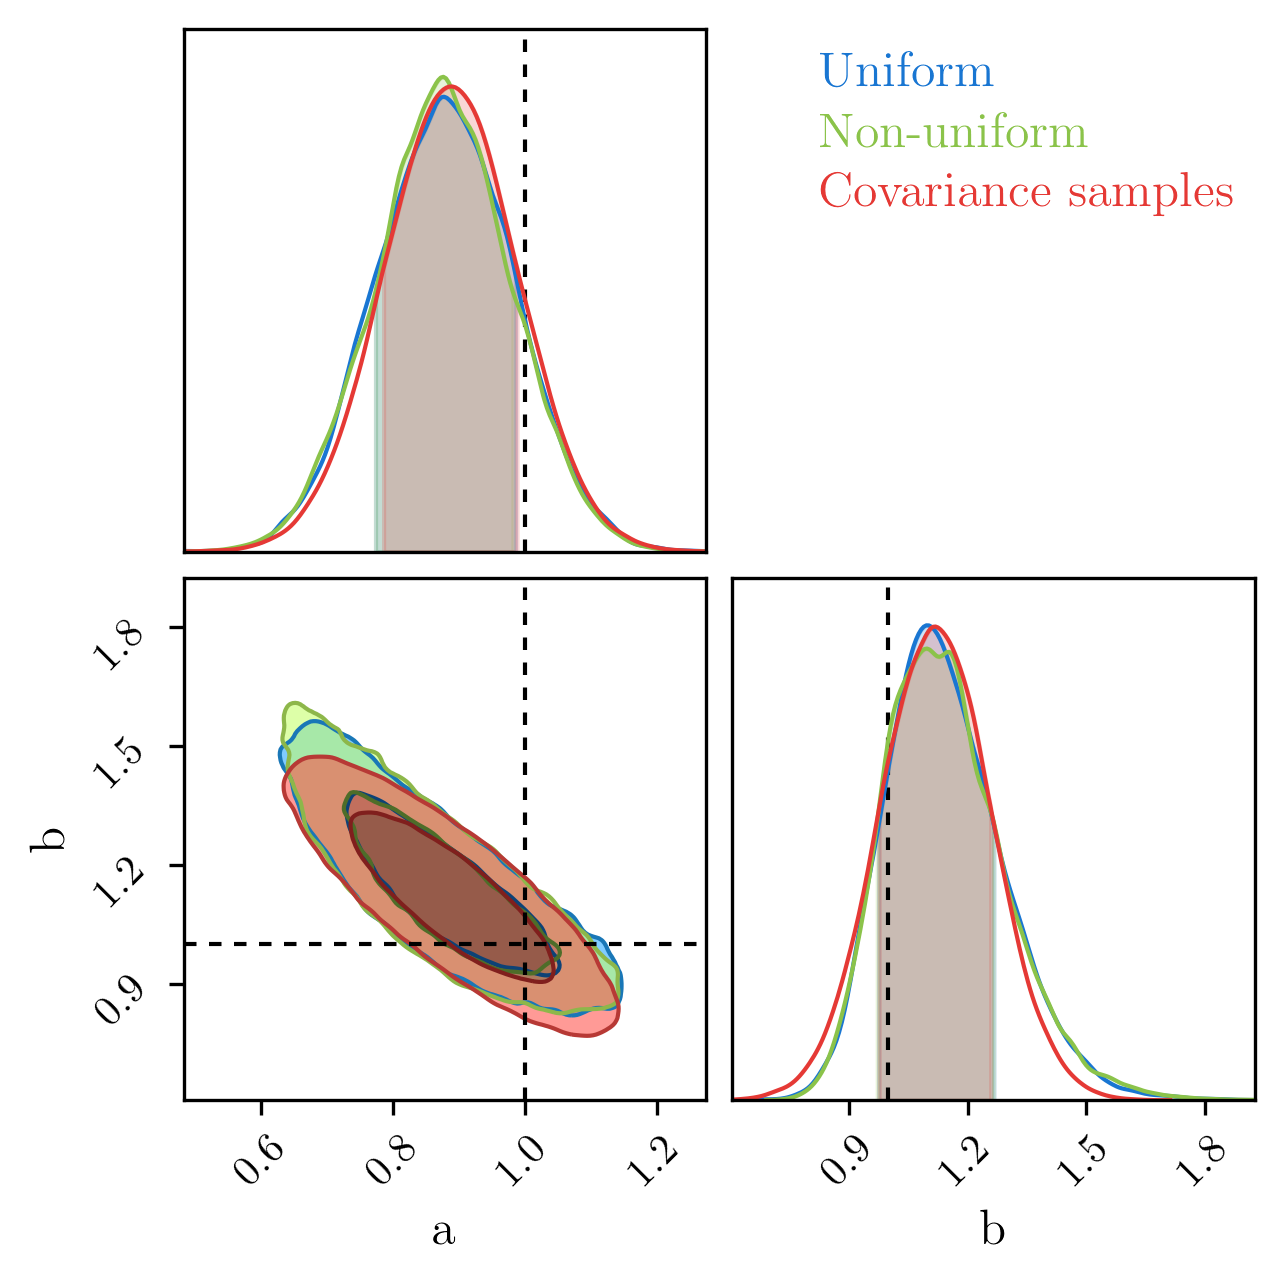

In [112]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
c.add_chain(uniform, parameters=["a", "b"], name="Uniform")
c.add_chain(non_uniform, weights=non_uniform_weights, name="Non-uniform")
c.add_chain(cov_samples, name="Covariance samples")
c.configure(flip=False)
c.plotter.plot(truth=truth, figsize=1.4);

You can see `emcee` and `nestle` (shown in blue and green respectively) agree perfectly. In red, the `leastsq` method shows some issues (as expected). The surface isn't a perfect normal and it cannot capture that detail with it's simplistic method and local estimation of uncertainty around the best fit point. Just something to keep in mind on why model fitting should essentially never be done with any such method.

In [113]:
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif')

# Propagating Uniform Samples - The Fast and Hard Way

Now that we have samplers, we can propagate them back into model space for visualisation (or scientific use). If we want blazing speed, we really have to make sure our model is vectorised, such that we can ask for a set of $N$ $x$ values and a set of $M$ values for $\theta$ (in our case, $\theta = \lbrace a, b \rbrace$) and get out an $N\times M$ result. If it cannot be vectorised, we'll handle that next.

The `realisation` line below shows a vectorised implementation of `fn`. Note that I'm using `prod` to speed up calculate $a\times b$ over all samples. So if we have $M$ samples, we now have $M$ realisations of our model at some input vector of `xs`. We can then ask `numpy` for the percentile across the first axis (corresponding to across the $M$ samples), and that will let us characterise the *distribution of our model values, given those samples, at each location in `xs`*, where we summarise the distribution by asking for the $1$ and $2\sigma$ limits that you can see being passed into `norm.cdf`. We then fill between those sigma-levels in the plot to produce the fully-propagated uncertainty bounds in our model space.

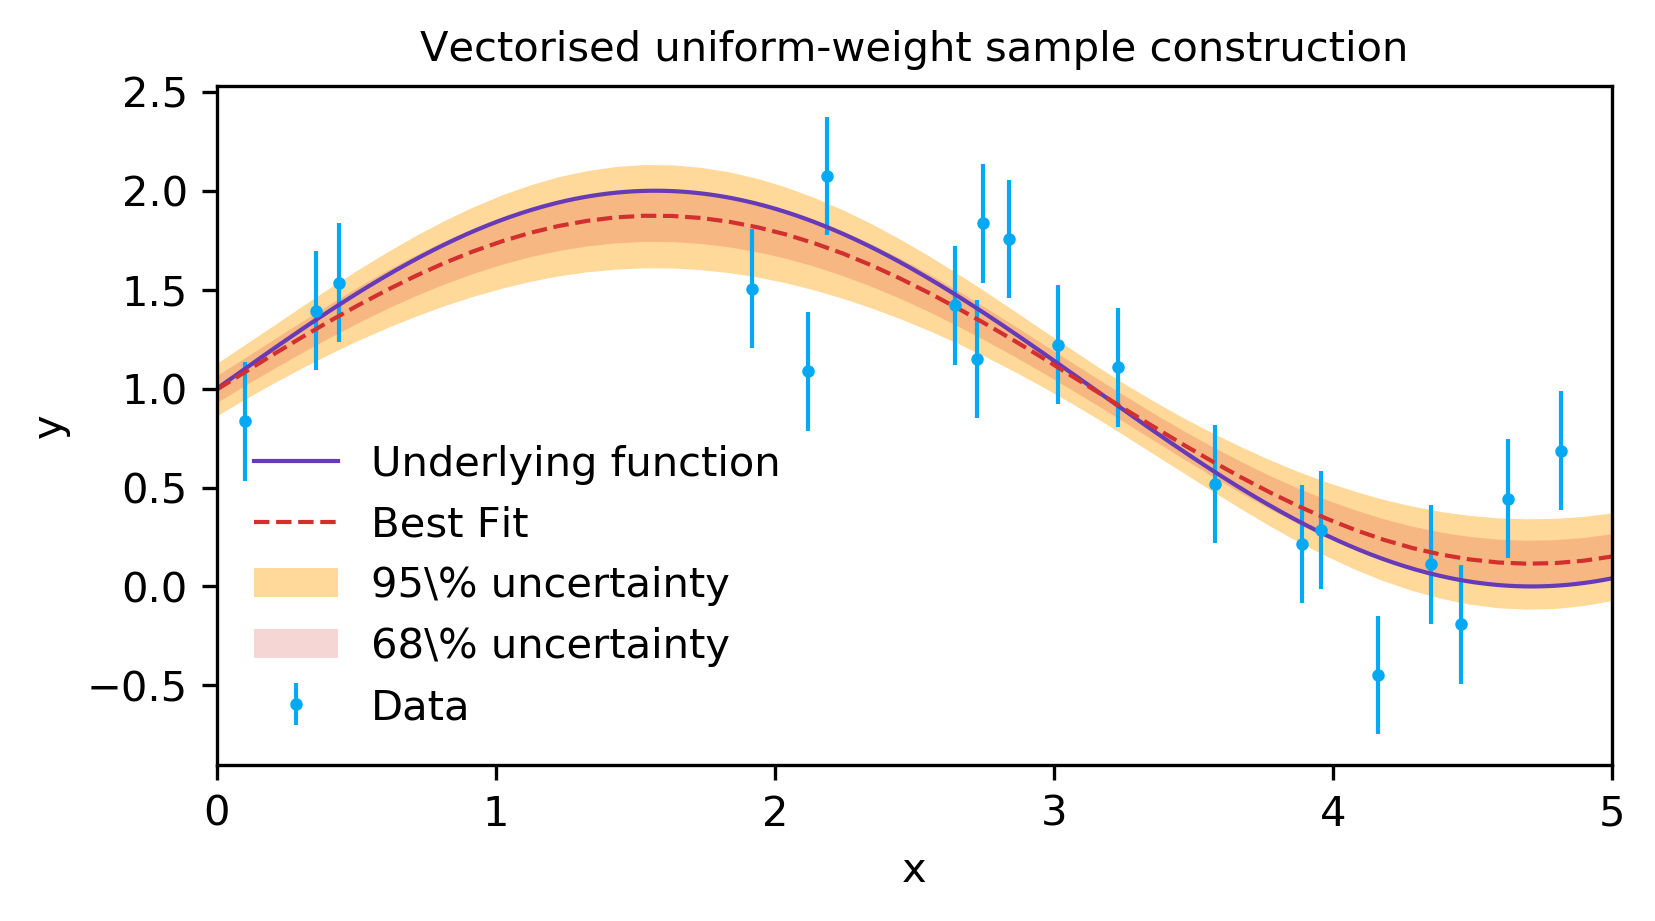

In [114]:
xs = np.linspace(0, 5, 50)
realisations = uniform[:, 0][:, None] * np.sin(xs) + uniform.prod(axis=1)[:, None]
bounds = np.percentile(realisations, 100 * norm.cdf([-2, -1, 0, 1, 2]), axis=0)

# Plot everything
def plot(bounds, title):
    fig, ax = plt.subplots()
    plt.plot(x_val, y_val, label="Underlying function")
    plt.errorbar(x_samps, y_samps, yerr=err, fmt="o", lw=1, label="Data")
    ax.plot(xs, bounds[2, :], label="Best Fit", ls="--"),
    plt.fill_between(xs, bounds[0, :], bounds[-1, :], 
                     label="95\% uncertainty", fc="#FFA000", alpha=0.4)
    plt.fill_between(xs, bounds[1, :], bounds[-2, :], 
                     label="68\% uncertainty", fc="#D32F2F", alpha=0.2)
    ax.legend(loc=3)
    ax.set_title(title, fontsize=10);
    ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_xlim(0, 5);
plot(bounds, "Vectorised uniform-weight sample construction")

# Propagating Uniform Samples - The Easy and Slow Way

So, we can't vectorise, our model isn't trivial enough, our lives are in ruin. Well, no matter, we can generate the model realisations one-by-one, and note that you don't need *all that many* realisations. We're characting a distribution to be able to plot it, so you'd only need around a thousand points to do it to sufficient accuracy. Firstly, we take our samples and shuffle them. Doing this isn't always needed, but some samplers have auto-correlation and shuffling is a good way to make sure you don't bias your plots by selecting the first thousand samples... which all happen to be right next to each other.

From there, we manually construct the realisations from the first thousand shuffled samples, and do exactly the same steps as before with `np.percentile`.

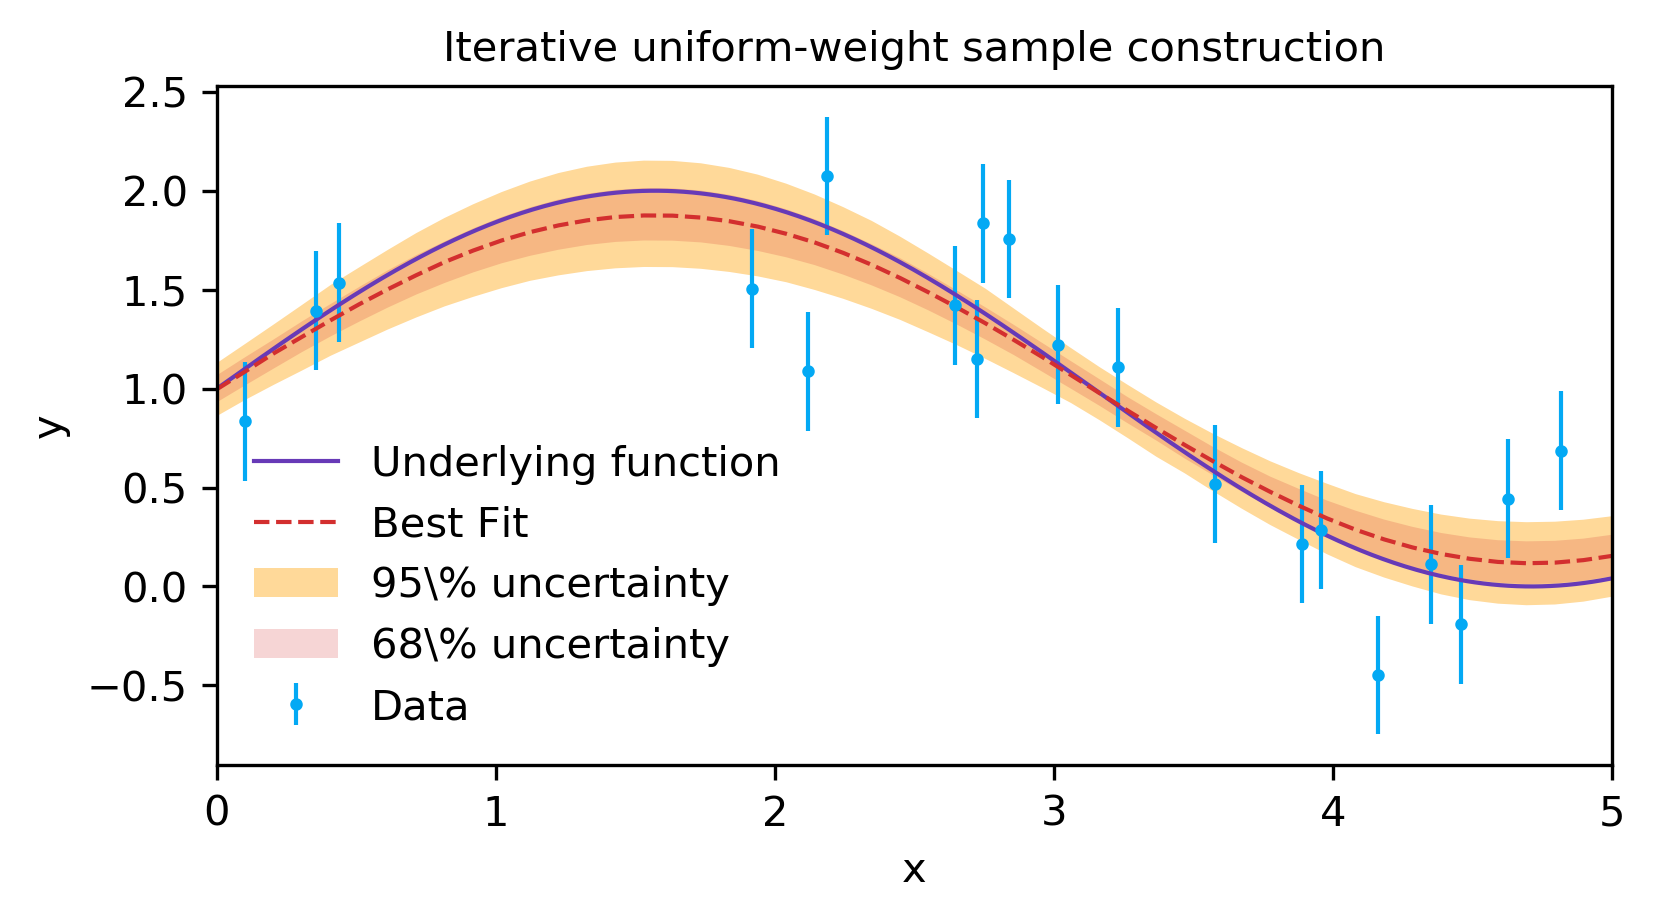

In [115]:
# Copy our samples then shuffle them to ensure randomness and low autocorrelation
shuffled = np.copy(uniform)
np.random.shuffle(shuffled)
# Row by row construct the prediction of our model using 1000 model realisations
realisations = np.array([fn(xs, row[0], row[1]) for row in shuffled[:1000, :]])
bounds = np.percentile(realisations, 100 * norm.cdf([-2, -1, 0, 1, 2]), axis=0)
plot(bounds, "Iterative uniform-weight sample construction")

# Non-uniformly weighted samples - The Hard and Slow Way

Finally, if we don't have uniformly-weighted samples, still no issue. It would be nice if `numpy.percentile` supported weights, but it doesn't, so what we'll do is resample from our samples such that they *become* equally weighted. We can do this via stock-standard rejection sampling. We have a weight (which we should make sure is normalised from 0 to 1 initially, if its not the normalise it), and we compare it against a random number drawn uniformly between 0 and 1. If our weight is above the random number, we keep that sample, if not, we move on.

So, a sample with weight $0.1$ will only appear in our final sample $10\%$ of the time. A sample with weight $0.5$ will be in it $50\%$ of the time. So we're dropping points according to their weight, and that means we can treat all samples that made the cut as having equal weight. In the code below, we do this step in one line to generate a `mask` which we can apply to our initial samples. We still shuffle them (for possible autocorrelation reasons), but then we do the same final steps as before.

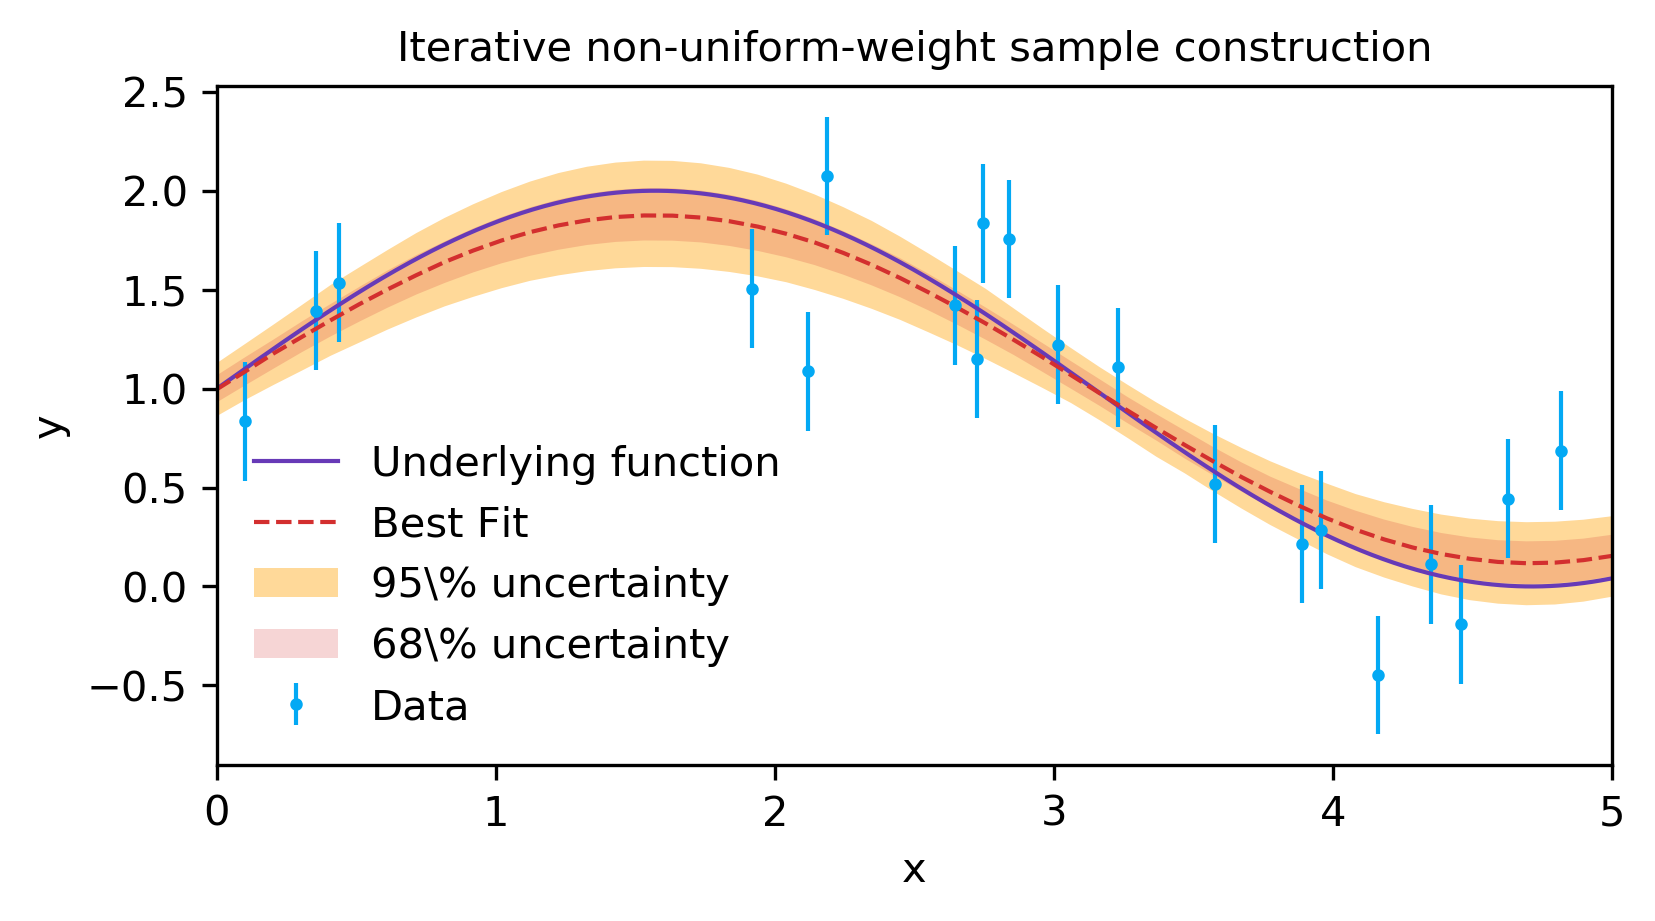

In [116]:
# Sample our weights according to their weight
mask = np.random.uniform(size=non_uniform_weights.shape) < non_uniform_weights
sampled = non_uniform[mask, :]
np.random.shuffle(sampled)


# Row by row construct the prediction of our model using 1000 model realisations
realisations = np.array([fn(xs, row[0], row[1]) for row in shuffled[:1000, :]])
bounds = np.percentile(realisations, 100 * norm.cdf([-2, -1, 0, 1, 2]), axis=0)
plot(bounds, "Iterative non-uniform-weight sample construction")

!!!main

And you should notice that all three mothods have produced exactly the same plot. Which is good. Hopefully these methods are useful!